In [62]:
#Libraries
from pyrocko.gf.seismosizer import BoxcarSTF, HalfSinusoidSTF, TriangularSTF, STF, SmoothRampSTF
from pyrocko.gf import RectangularSource, LocalEngine, Target, CombiSource, DoubleDCSource, DCSource, ws
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import obspy
from scipy import integrate
from scipy import signal
from pyproj import CRS, Transformer
from numpy.random import randn
from numpy import where
from scipy.interpolate import interp1d
from geopy import distance
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import taup_create, TauPyModel
from scipy.linalg import expm
from scipy.integrate import cumtrapz
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
from pathlib import Path
from numpy import genfromtxt,zeros,arctan2,sin,r_,where,log10,isnan,argmin,setxor1d,exp
from numpy .random import rand,randn,randint
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
import warnings
import math
import os
import glob
import numpy as np
from scipy import signal
from obspy.signal.detrend import polynomial
from obspy.signal.filter import bandpass

## Slip Distribution:

**Using the slip distribution from the USGS model:**

https://earthquake.usgs.gov/earthquakes/eventpage/us20003k7a/finite-fault 

This code receives: 

1. Slip distribution.
2. Lat, Lon of each subfault (considered in the center of each subfault).
3. Depth (Z).
4. Rake, dip, and strike as scalar values.
5. Length (distance along-strike), width (distance along-dip), and Dx and Dz of each subfaults.
6. Hypocentre location.

In [3]:
# Charge the subfaults of the Illapel .csv
subfaults = pd.read_csv("Illapel_slip.csv")
print(np.shape(subfaults))
subfaults.head(449)

(450, 6)


,LAT,LON,X==EW,Y==NS,Z,SLIP
0,-32.3840,-72.5657,-87.9776,-87.6472,3.215,0.5812
1,-32.2766,-72.5524,-86.8310,-75.6947,3.215,0.8676
2,-32.1692,-72.5392,-85.6812,-63.7424,3.215,1.3500
3,-32.0618,-72.5259,-84.5236,-51.7902,3.215,1.9342
4,-31.9544,-72.5127,-83.3722,-39.8383,3.215,2.5841
...,...,...,...,...,...,...
444,-30.4764,-70.8276,76.8664,124.5597,51.920,0.0692
445,-30.3690,-70.8143,78.2376,136.4921,51.920,0.0764
446,-30.2616,-70.8011,79.5923,148.4244,51.920,0.0117
447,-30.1542,-70.7878,80.9689,160.3565,51.920,0.0076


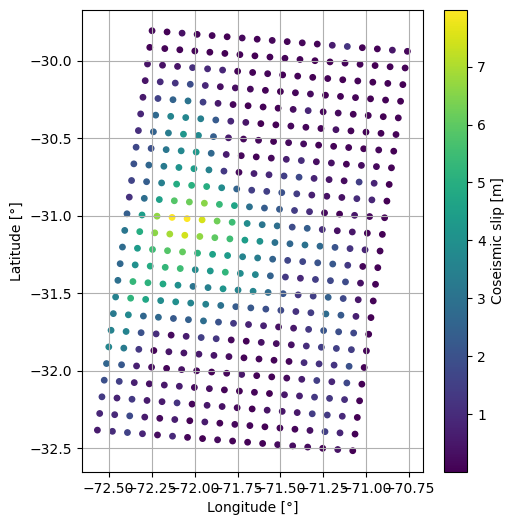

In [4]:
# Plot the distribution of sub-sources 
plt.figure(figsize=(5.5, 6))
plt.scatter(subfaults['LON'], subfaults['LAT'], c=subfaults['SLIP'], cmap='viridis', s=15)
plt.colorbar(label="Coseismic slip [m]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.grid()
plt.show()

In [5]:
# Global fault parameters:
LENGTH = 300.0*1000  # Total length in m 
WIDTH = 158.4*1000  # Total width in m 
DX = 12.0*1000  # Fixed dimension of each cell (m)
DZ = 8.8*1000  # Fixed dimension of each cell (m)
Lat_hyp = -31.5952 # Hypocentre latitude 
Lon_hyp = -71.6728  # Hypocentre longitude 
Z_hyp= 29.0 # Hypocentre Depth (km)

## Kinematic Rupture:

**Moment calculation according to the velocity model:**

In [36]:
# Reading the velocity model
velocity_model_file = 'Husen_model_Chile.txt'
velocity_data = []
with open(velocity_model_file, 'r') as file:
    for line in file:
        # Skip header or comment lines
        if line.startswith('#') or not line.strip():
            continue
        # Read numeric values from the model
        values = list(map(float, line.split()))
        velocity_data.append(values)

# Convert to DataFrame
velocity_model = pd.DataFrame(velocity_data, columns=['DEPTH', 'P-VEL', 'S-VEL', 'DENS', 'QP', 'QS'])

# Function to interpolate G based on depth Z
def interpolate_shear_modulus(Z, model):
    for i in range(len(model) - 1):
        if Z <= model['DEPTH'].iloc[i] * 1000:  # Z in m
            rho = model['DENS'].iloc[i] * 1000  # Density in kg/m³
            vs = model['S-VEL'].iloc[i] * 1000    # Convert Vs to m/s
            return rho * vs**2  # G in Pa
            
    # If outside the model range
    rho = model['DENS'].iloc[-1] * 1000
    vs = model['S-VEL'].iloc[-1] * 1000
    return rho * vs**2

# Calculate G for each subfault in Pa
G = np.array([interpolate_shear_modulus(z, velocity_model) for z in subfaults['Z']*1000])  

# Area in each subfault in m²
A = DX * DZ

# Moment in each subfault in Nm
subfaults['SF_MOMENT'] = G * A * subfaults['SLIP']
subfaults['SF_MOMENT']

0      1.623844e+18
1      2.424031e+18
2      3.771833e+18
3      5.404058e+18
4      7.219846e+18
           ...     
445    5.473057e+17
446    8.381515e+16
447    5.444403e+16
448    5.824078e+17
449    1.105357e+18
Name: SF_MOMENT, Length: 450, dtype: float64

**Rake calculation:**

In [9]:
def sample_rake(mean_rake, n, std = 10.0, max_variation = 45.0):
    """
    Generate a stochastic rake array of length n, centered around base_rake
    with standard deviation std, clipped to +/- max_variation from base_rake.
    -----
    This is a simple stochastic perturbation + bounding step. This function is based on
    Graves & Pitarka (2010) and Melgar et al. (2016) from Fakequakes.
    """

    # perturbations
    perturb = randn(n)
    rake = std * perturb  + mean_rake

    lower, upper = mean_rake - max_variation, mean_rake + max_variation
    return np.clip(rake, lower, upper)


In [10]:
rake_value = 105.0
Nsamples = len(subfaults["SLIP"])

subfaults["RAKE"] = sample_rake(
    mean_rake=rake_value,
    n=Nsamples
)
subfaults['RAKE']

0      110.439453
1       94.081195
2       89.429245
3      100.737651
4      119.642143
          ...    
445    104.694042
446    112.451774
447     95.767322
448     97.998174
449     88.406871
Name: RAKE, Length: 450, dtype: float64

**Dip and Strike of the earthquake:**

In [12]:
#In this case this information comes from the USGS inversion
dip = 19.0
strike = 6.0

**Rupture Time calculation:**

In [14]:
def get_rupture_time(home,slip,fault_array,model_name,hypocentre,
        rise_time_depths,M0,velmod,sigma_rise_time=0.2,shear_wave_fraction_shallow=0.49,shear_wave_fraction_deep=0.8):
    
    home,slip,fault_array,model_name,hypocentre,rise_time_depths,M0,velmod,shear_wave_fraction_shallow,shear_wave_fraction_deep
    
    """
    Compute stochastic rupture times (t_rupture) for each subfault.

    Method summary
    --------------
    1) We estimate a deterministic rupture-front travel time from the hypocentre to
       each subfault using a 1-D layered velocity model and a straight-ray, layer-by-layer
       travel-time calculation. Rupture speed is prescribed as a depth-dependent fraction
       of S-wave velocity (Vs), transitioning between a shallow and deep multiplier.

    2) We add a stochastic perturbation to the deterministic times following the
       Graves & Pitarka-style formulation (e.g., slip-correlated perturbation via log10(slip),
       with a magnitude-dependent scale and a lognormal factor controlled by sigma_rise_time).

    3) We enforce physical constraints: non-negative times, hypocentre time = 0, and we
       reject perturbations that would imply P-wave arrivals earlier than the hypocentre
       (iteratively redrawing the perturbation up to a maximum number of attempts).

    Attribution
    -----------
    This implementation is adapted from Fakequakes by Melgar et al. (2016),
    and follows the stochastic-rupture parameterization concepts developed by Graves & Pitarka
    (e.g., rupture-time perturbations correlated with slip).
    """
    
    #warnings.filterwarnings("ignore")
    
    #Load velocity model
    vel=genfromtxt(home+'/structure/'+model_name)
        
    # Convert from thickness to depth to bottom of layer
    depth_to_top=r_[0,vel[:,0].cumsum()[0:-1]]
        
    #Get rupture speed shear-wave multipliers
    rupture_multiplier=zeros(len(vel))
    # Shallow 
    i=where(depth_to_top<=rise_time_depths[0])[0]
    rupture_multiplier[i]=shear_wave_fraction_shallow
    # Deep 
    i=where(depth_to_top>=rise_time_depths[1])[0]
    rupture_multiplier[i]=shear_wave_fraction_deep
    # Transition 
    i=where((depth_to_top<rise_time_depths[1]) & (depth_to_top>rise_time_depths[0]))[0]
    slope=(shear_wave_fraction_deep-shear_wave_fraction_shallow)/(rise_time_depths[1]-rise_time_depths[0])
    intercept=shear_wave_fraction_deep-slope*rise_time_depths[1]
    rupture_multiplier[i]=slope*depth_to_top[i]+intercept
    
    #Perturb depths of the hypocentre so that faults at the same depth are not zero onset
    delta=0.00001
    i_same_as_hypo=where(fault_array[:,3]==hypocentre[2])[0]
    dist=((fault_array[:,1]-hypocentre[0])**2+(fault_array[:,2]-hypocentre[1])**2)**0.5
    i_hypo=argmin(dist)

    #Get faults at same depth that are NOT the hypo
    i_same_as_hypo=setxor1d(i_same_as_hypo,i_hypo)
    #perturb
    R=rand(1)[0]
    fault_array[i_hypo,3]=fault_array[i_hypo,3]-delta*R
    hypocentre[2]=hypocentre[2]-delta*R
    R=rand(len(i_same_as_hypo))
    fault_array[i_same_as_hypo,3]=fault_array[i_same_as_hypo,3]+delta*R
    
    #Loop over all faults
    t_rup=zeros(len(slip))
    length2fault=zeros(len(slip))
    #Perturb all subfault depths a tiny amount by some random number so that they NEVER lie on a layer interface
    z_perturb=(rand(len(fault_array))-0.5)*1e-6
    fault_array[:,3]=fault_array[:,3]+z_perturb
    for kfault in range(len(slip)):
        D,az,baz=gps2dist_azimuth(hypocentre[1],hypocentre[0],fault_array[kfault,2],fault_array[kfault,1])
        D=D/1000
        #Start and stop depths
        if fault_array[kfault,3]<=hypocentre[2]:
            zshallow=fault_array[kfault,3]
            zdeep=hypocentre[2]
        else:
            zdeep=fault_array[kfault,3]
            zshallow=hypocentre[2]
        #Get angle between depths
        theta=arctan2(zdeep-zshallow,D)
        # get hypotenuse distance on all layers
        delta_ray=vel[:,0]/sin(theta)
        # Calculate distance in each layer
        depth1=0
        depth2=vel[0,0]
        length_ray=zeros(len(vel))
        for klayer in range(len(vel)):
            if zshallow>depth1 and zdeep<depth2: #both points in same layer
                length_ray[klayer]=abs(zshallow-zdeep)/sin(theta) 
            elif zshallow>depth1 and zshallow<depth2: #This is the top
                length_ray[klayer]=abs(depth2-zshallow)/sin(theta)
            elif zdeep>depth1 and zdeep<depth2: #This is the bottom
                length_ray[klayer]=abs(depth1-zdeep)/sin(theta)
            elif depth1>zshallow and depth2<zdeep: #Use full layer thickness for ray path length
                length_ray[klayer]=delta_ray[klayer]
            else: #Some other layer, do nothing
                pass
            #Update reference depths
            if klayer<len(vel)-1: #last layer:
                depth1=depth2
                depth2=depth2+vel[klayer+1,0]
            else:
                depth1=depth2
                depth2=1e6
        
        
        #Multiply ray path length times rupture velocity
        ray_times=length_ray/(vel[:,1]*rupture_multiplier)
        t_rup[kfault]=ray_times.sum()  
        length2fault[kfault]=(ray_times*vel[:,1]*rupture_multiplier).sum()
        
    #Perturb onset times according to Graves-Pitarka eq 5 and 6 (assumes 1:1 corelation with slip)
    delta_t0=((M0*1e7)**(1./3))*1.8e-9
    
    #GP 2015 extra perturbation to destroy the 1:1 correlation with slip
    rand_numb=randn()
    delta_t=delta_t0*exp(sigma_rise_time*rand_numb)
    
    #Now apply total perturbation
    slip_average=slip.mean()
    i=where(slip>0.05*slip_average)[0] #perturbation is applied only to subfaults with significant slip
    perturbation=(log10(slip)-log10(slip_average))/(log10(slip.max())-log10(slip_average))
    t_rup_final=t_rup.copy()
    t_rup_final[i]=t_rup[i]-delta_t*perturbation[i]
    
    #No negative times
    i=where(t_rup_final<0)[0]
    t_rup_final[i]=t_rup[i]
        
    # Enforce P-wave causality constraint
    for kfault in range(len(slip)):
        D,az,baz=gps2dist_azimuth(hypocentre[1],hypocentre[0],fault_array[kfault,2],fault_array[kfault,1])
        D=D/1000
        D_deg=kilometer2degrees(D)
        Ppaths=velmod.get_ray_paths(hypocentre[2],D_deg,phase_list=['P','p'])
        
        try:
            Ptime=Ppaths[0].time
        except:
            print('Ptime ERROR')
            print('   Target is:')
            print('     '+str(fault_array[kfault,0:4]))
            print('   Hypo is:')
            print('     '+str(hypocentre))
        attempt=1
        while (t_rup_final[kfault] < Ptime) & (attempt < 500):
            rand_numb=randn()
            delta_t=delta_t0*exp(sigma_rise_time*rand_numb*(1./attempt))
            perturbation=(log10(slip[kfault])-log10(slip_average))/(log10(slip.max())-log10(slip_average))
            t_rup_final[kfault]=t_rup[kfault]-delta_t*perturbation
            attempt+=1
            if attempt == 500:
                t_rup_final[kfault]=t_rup[kfault]
                #print("...Failed at subfault " + str(kfault)
            #GP 2015 extra perturbation to destroy the 1:1 correlation with slip
            t_rup_final[kfault]=t_rup[kfault]

    # Hypocentre rupture time is zero
    t_rup_final[i_hypo]=0
    
    #Check for nan times
    i=where(isnan(t_rup_final)==True)[0]
    t_rup_final[i]=0

    return t_rup_final,length2fault  

In [15]:

home = 'C:/Users/angie/Documents/Kinematic_test'    

slip = subfaults['SLIP'].values

fault_array = np.column_stack((
    np.zeros(len(subfaults)),               # Column 0: identifier (placeholder)
    subfaults['LON'].values,                # Column 1: longitude
    subfaults['LAT'].values,                # Column 2: latitude
    subfaults['Z'].values,                  # Column 3: depth (km)
    np.full(len(subfaults),strike),         # Column 4: strike (constant at 6.0)
    np.full(len(subfaults), dip)             # Column 5: dip (constant at 19.0)
))
model_name = 'chile_husen_model.mod'

Lat_hyp = Lat_hyp
Lon_hyp = Lon_hyp
Z_hyp = Z_hyp
hypocentre = np.array([Lon_hyp, Lat_hyp, Z_hyp]) # [lon, lat, depth]

rise_time_depths = [10.0, 15.0]  # in kilometers 
M0 =   2.9107715e+21 # This value was taken from USGS inversion
# 1-D velocity model for ray tracing (TauP)
velmod = TauPyModel(model='C:/Users/angie/Documents/Kinematic_test/structure/chile_husen_model.npz')  


t_rup_final, length2fault = get_rupture_time(home, slip, fault_array, model_name,
                                                hypocentre, rise_time_depths, M0, velmod,
                                                sigma_rise_time=0.2, shear_wave_fraction_shallow=0.3,
                                                shear_wave_fraction_deep=0.5)

In [16]:
subfaults['TRUP'] = t_rup_final

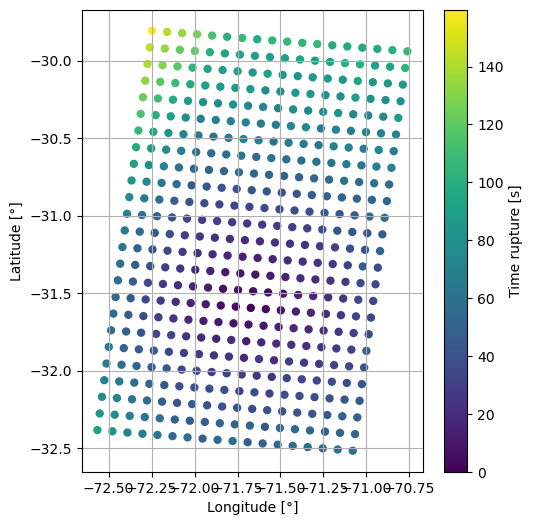

In [17]:
plt.figure(figsize=(5.5, 6))
plt.scatter(subfaults['LON'], subfaults['LAT'], c=subfaults['TRUP'], cmap='viridis', s=25)
plt.colorbar(label="Time rupture [s]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.grid()
plt.show()

**Rupture Velocity Calculation:**

In [19]:
Vr_sub = np.zeros(len(subfaults))  # Initialize Vr as a zero array

for cell_idx, subfault in subfaults.iterrows():
    # Subfault coordinates (latitude and longitude)
    lat_dc = subfault['LAT']
    lon_dc = subfault['LON']

    # Subfault depth (in meters)
    z_sub = subfault['Z']
    
    # Horizontal distance between the subfault and the hypocenter (meters)
    d_hor = distance.distance((lat_dc, lon_dc), (Lat_hyp, Lon_hyp)).meters

    # Vertical depth difference (in meters)
    # d_vert = abs(z_sub - Z_hyp)
    
    # 3-D distance between the subfault and the hypocenter
    # d_3d = np.sqrt(d_hor**2 + d_vert**2)

    subfault['dip_rad'] = np.deg2rad(dip)
    d_3d = d_hor / math.cos(subfault['dip_rad'])
    
    # If TRUP is NaN or zero, assign zero; otherwise compute rupture speed
    if np.isnan(subfault['TRUP']) or subfault['TRUP'] == 0:
        Vr_sub[cell_idx] = 0
    else:
        Vr_sub[cell_idx] = d_3d / subfault['TRUP']

# Note: Here we assign Vr = 0 when TRUP is NaN or zero, so the mean includes those zeros.
# If you prefer, compute the mean only where TRUP > 0 (or where Vr_sub > 0).

Vr_mean = np.mean(Vr_sub)
print(Vr_mean)

Vr_sub.shape
subfaults['Vr'] = Vr_sub
Vr_sub


1937.4128274161537


array([1368.13879935, 1381.16896521, 1399.38172472, 1415.88610211,
       1430.67852899, 1453.1761375 , 1447.13879168, 1436.50451492,
       1441.94364015, 1427.67202296, 1423.16409649, 1431.77648803,
       1445.21865334, 1429.93750034, 1389.41275783, 1415.54657523,
       1432.96244281, 1427.51674103, 1409.68675402, 1404.32828007,
       1390.28696875, 1385.57325132, 1388.98094525, 1435.56590475,
       1363.60692652, 1481.4252584 , 1470.41931173, 1448.43463398,
       1489.15134538, 1513.10415779, 1547.68220319, 1552.53440008,
       1555.4051264 , 1592.65516331, 1595.45400578, 1564.4992415 ,
       1576.54692082, 1590.57826606, 1581.28709824, 1545.47727795,
       1533.94530557, 1543.82810769, 1527.17222605, 1543.39125334,
       1548.90210921, 1522.46545208, 1502.31342063, 1466.20989807,
       1525.48280782, 1526.64497824, 1630.09144927, 1633.96695914,
       1603.01824651, 1532.44960953, 1520.00259737, 1567.51796928,
       1613.52332922, 1644.41723866, 1734.87327152, 1748.16657

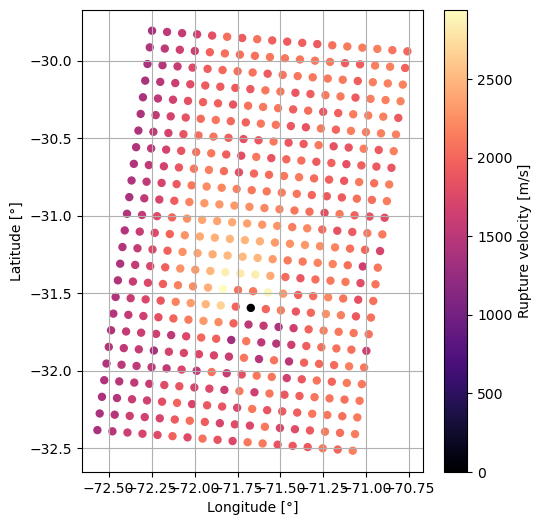

In [20]:
plt.figure(figsize=(5.5, 6))
plt.scatter(subfaults['LON'], subfaults['LAT'], c=Vr_sub, cmap='magma', s=25)
plt.colorbar(label="Rupture velocity [m/s]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.grid()
plt.show()

**Rise time calculation:**

In [23]:
def get_rise_time(M0,slip,fault_array,rise_time_depths,stoc_rake,rise_time='MH2017',rise_time_std=0.1,option=0, slip_velocity=1.0):

    '''
    Calculate individual subfault rise times

    rise_time:
      - 'MH2017', 'GP2015', 'S1999'  -> stochastic scaling
      - 'SLIPVEL'                    -> rise_times = slip / slip_velocity
    option:
      - if option==1 -> SLIPVEL
    '''

    # slip rate = risetime/slip = 1m/s
    if (rise_time.upper() == 'SLIPVEL') or (option == 1):
        slip_arr = np.asarray(slip, dtype=float)
        return slip_arr / float(slip_velocity)

    # -----------------------------------------------------------------------
    # Stocastic scalling based on Fakequakes (Melgar et al. 2016)
    # -----------------------------------------------------------------------

    # Moment to dyne-cm
    M0 = M0 * 1e7

    # Determine average rise time based on total moment
    if rise_time == 'GP2015':
        tau_average = 1.45 * 1e-9 * M0**(1./3)
    elif rise_time == 'S1999':
        tau_average = 2.0 * 1e-9 * M0**(1./3)
    elif rise_time == 'MH2017':
        tau_average = 4.226 * 1e-8 * M0**(0.293)

    # Determine slope and intercept of k-scaling line
    slope = 1.0 / (rise_time_depths[0] - rise_time_depths[1])
    intercept = 1 - slope * rise_time_depths[1]

    # Get rakes
    rake = stoc_rake.copy()
    i = np.where(rake < 0)[0]
    rake[i] = 360 + rake[i]
    rake = rake.mean()

    # Apply GP 2015 FR value
    if (rake > 0 and rake < 180):
        FR = 1 - (rake - 90) / 90.
    else:
        FR = 0

    # GP 2015 FD value
    dip = fault_array[:, 5].mean()
    if dip > 45:
        FD = 1 - (dip - 45) / 45.
    else:
        FD = 1

    # GP 2015 alpha_t
    alpha = 1.0 / (1 + FD * FR * 0.1)

    # rescale average rise time
    tau_average = tau_average * alpha

    # Depth scaling
    depth_scale = np.ones(len(fault_array))
    ishallow = np.where(fault_array[:, 3] <= rise_time_depths[0])[0]
    depth_scale[ishallow] = 2
    itransition = np.where((fault_array[:, 3] > rise_time_depths[0]) &
                           (fault_array[:, 3] < rise_time_depths[1]))[0]
    depth_scale[itransition] = slope * fault_array[itransition, 3] + intercept

    slip_arr = np.asarray(slip, dtype=float)

    # scaling constant k
    k = (len(slip_arr) * tau_average) / (np.sum(depth_scale * slip_arr**0.5))

    # Stochastic perturbations
    rand_num = randn(len(slip_arr))
    perturbations = np.exp(rise_time_std * rand_num)

    # Rise times
    rise_times = perturbations * depth_scale * k * (slip_arr**0.5)

    return rise_times


In [24]:
stoc_rake = subfaults['RAKE']
subfaults['RISE'] =get_rise_time(M0,slip,fault_array,rise_time_depths,stoc_rake, rise_time='S1999',rise_time_std=0.1)

In [25]:
subfaults['RISE']

0       5.999156
1       7.827828
2       9.322486
3      12.021262
4      13.536356
         ...    
445     1.203448
446     0.535333
447     0.366304
448     1.064783
449     1.812144
Name: RISE, Length: 450, dtype: float64

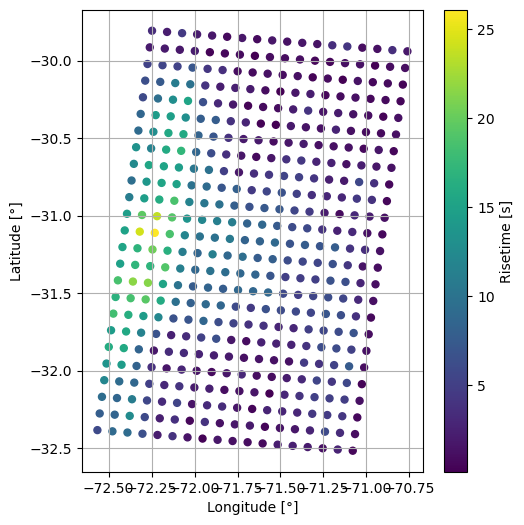

In [26]:
plt.figure(figsize=(5.5, 6))
plt.scatter(subfaults['LON'], subfaults['LAT'], c=subfaults['RISE'] , cmap='viridis', s=25)
plt.colorbar(label="Risetime [s]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.grid()
plt.show()

## From low resolution to high resolution:

**Discretization of the plane fault:**

In [29]:
# Minimum distance between point sources calculation:
vs_min = 2.99*1000  # Minimum shear wave velocity in m/s
f_max = 2.0  # Maximum frequency in Hz
lambda_min = vs_min / f_max  # Minimum wavelength
de_min = lambda_min / 5  # Maximum allowed spacing between sub-sources (m)
print(f"Minimum allowed spacing between sub-sources (de_min): {de_min} m")

# Global fault parameters:
LENGTH = LENGTH  # Total length in m 
WIDTH = WIDTH  # Total width in m 
DX = DX  # Fixed dimension of each cell (m)
DZ = DZ  # Fixed dimension of each cell (m)
NX = LENGTH / DX  # Number of cells along the length
NZ = WIDTH / DZ  # Number of cells along the width

# Calculate the exact center coordinates of the rupture
# Using the maximum and minimum latitude and longitude of sub-sources:
test_LAT = (subfaults['LAT'].max() + subfaults['LAT'].min()) / 2
test_LON = (subfaults['LON'].max() + subfaults['LON'].min()) / 2
print(f"Exact center latitude (test_LAT): {test_LAT}")
print(f"Exact center longitude (test_LON): {test_LON}")

# Calculate the number of sub-sources per cell based on de_min:
def calculate_subsources_per_cell(dx, dz, de_min):
    # Round up to ensure compliance with de_min
    sub_x = int(np.ceil(dx / de_min))  # Number of sub-sources in the X direction within the cell
    sub_z = int(np.ceil(dz / de_min))  # Number of sub-sources in the Z direction within the cell
    return sub_x * sub_z  # Total sub-sources within a cell

N_SUB_SOURCES = calculate_subsources_per_cell(DX, DZ, de_min)

dist_max = de_min  # Maximum distance in meters

# Number of divisions in each direction:
divisions_NX = int(np.ceil(DX / dist_max))  # Total divisions along the length of the sub-source
divisions_NZ = int(np.ceil(DZ / dist_max))  # Total divisions along the width of the sub-source


# Number of point sources in LENGTH and WIDTH of the main source:
nx_sources = int(NX * divisions_NX)
nz_sources = int(NZ * divisions_NZ)


print(f"Cell dimensions DX: {DX} m, DZ: {DZ} m")
print(f"Number of cells in the fault plane NX: {NX}, NZ: {NZ}")
print(f"Number of sub-sources per cell: {N_SUB_SOURCES}")
print(f"Number of divisions per cell nx: {divisions_NX}, nz: {divisions_NZ}")
print(f"Number of point sources in Length: {nx_sources}")
print(f"Number of point sources in Width: {nz_sources}")
print(f"Total number of point sources: {nx_sources * nz_sources}")

Minimum allowed spacing between sub-sources (de_min): 299.0 m
Exact center latitude (test_LAT): -31.161700000000003
Exact center longitude (test_LON): -71.6635
Cell dimensions DX: 12000.0 m, DZ: 8800.0 m
Number of cells in the fault plane NX: 25.0, NZ: 18.0
Number of sub-sources per cell: 1230
Number of divisions per cell nx: 41, nz: 30
Number of point sources in Length: 1025
Number of point sources in Width: 540
Total number of point sources: 553500


In [30]:
 """
    Adds UTM coordinates and shifts them to a local reference frame (origin at the epicenter).
    Creates/overwrites subfaults["X_m"] and subfaults["Y_m"].
    """
# Define the WGS84 and UTM Zone 19S projections
crs_wgs84 = CRS("EPSG:4326")  # WGS84 (lat/lon)
crs_utm = CRS("EPSG:32719")  # UTM Zone 19S

# Create the transformer
transformer = Transformer.from_crs(crs_wgs84, crs_utm, always_xy=True)

# Extract the epicenter latitude and longitude (assuming X=0, Y=0 in the file)
epicentro_lon = -71.6728
epicentro_lat = -31.5952

# Transform to UTM coordinates
epicentro_x, epicentro_y = transformer.transform(epicentro_lon, epicentro_lat)

# Transform all subfaults
#subfaults["X_m"], subfaults["Y_m"] = transformer.transform(subfaults["Y==NS"].values, subfaults["X==EW"].values)
subfaults["X_m"], subfaults["Y_m"] = transformer.transform(subfaults["LON"].values, subfaults["LAT"].values)

# Shift to a local reference frame (origin at the epicenter)
subfaults["X_m"] -= epicentro_x
subfaults["Y_m"] -= epicentro_y

In [31]:
def calculate_subsources_pos(divisions_NX, divisions_NZ, DX, DZ, subfault):
    """
    Compute the positions of a fine subsource grid inside a grid of low resolution.

    This function discretizes a single subfault into divisions_NX × divisions_NZ subsources
    over the subfault dimensions (DX along strike-direction in the local grid, DZ along dip-direction
    in the local grid). It builds a centered local (X, Z) grid, applies rotations for a fixed dip and
    strike, and then converts the rotated local coordinates into global geographic coordinates
    (longitude, latitude) and depth. It also outputs global Cartesian offsets (X_m, Y_m) relative to
    a global/local origin previously stored in the input `subfault` (subfault['X_m'], subfault['Y_m']).

    Returns
    -------
    lon : ndarray
        Longitude of each subsource [degrees].
    lat : ndarray
        Latitude of each subsource [degrees].
    depth : ndarray
        Depth of each subsource [m].
    aux_X : ndarray
        Global X position of each subsource [m] (equivalent to 'X[m]').
    aux_Y : ndarray
        Global Y position of each subsource [m] (equivalent to 'Y[m]').
    """

    # Distance between each subsource:
    dx = DX / divisions_NX
    dz = DZ / divisions_NZ
    
    # Initialize variables
    X = np.zeros(divisions_NX * divisions_NZ)
    Z = np.zeros(divisions_NX * divisions_NZ)
    depth = np.zeros(divisions_NX * divisions_NZ) 
    lon = np.zeros(divisions_NX * divisions_NZ)
    lat = np.zeros(divisions_NX * divisions_NZ)

    # Filling the matrix to create the local grid:
    for j in range(divisions_NZ):
        for i in range(divisions_NX):
            X[j * divisions_NX + i] = dx * i 
            Z[j * divisions_NX + i] = dz * j 
    # Center the local grid coordinates:
    X = X + dx/2 - DX/2  
    Z = Z + dz/2 - DZ/2  
    
    dip = 19.0
    strike = 6.0
    
    # Rotate the grid coordinates on dip:
    aux_X = X
    aux_Z = Z * np.cos(np.deg2rad(dip))
    depth = Z * np.sin(np.deg2rad(dip)) + (subfault['Z']*1000)

    # Rotate the grid coordinates around strike:
    rotated_x = aux_X * np.cos(np.deg2rad(strike)) - aux_Z * np.sin(np.deg2rad(strike))
    rotated_z = aux_X * np.sin(np.deg2rad(strike)) + aux_Z * np.cos(np.deg2rad(strike))

    # Convert local rotated coordinates to global geographic coordinates (latitude and longitude):
    lat = subfault['LAT'] + (rotated_x / 110574)

    # Calculate longitude for each point:
    for i in range(divisions_NX * divisions_NZ):
        lon[i] = subfault['LON'] + rotated_z[i] / (111320 * np.cos(np.deg2rad(lat[i])))

    # Calculate Global Failure X and Y positions:
    aux_X = rotated_z + subfault['X_m']
    aux_Y = rotated_x + subfault['Y_m']
    
    return lon, lat, depth, aux_X, aux_Y


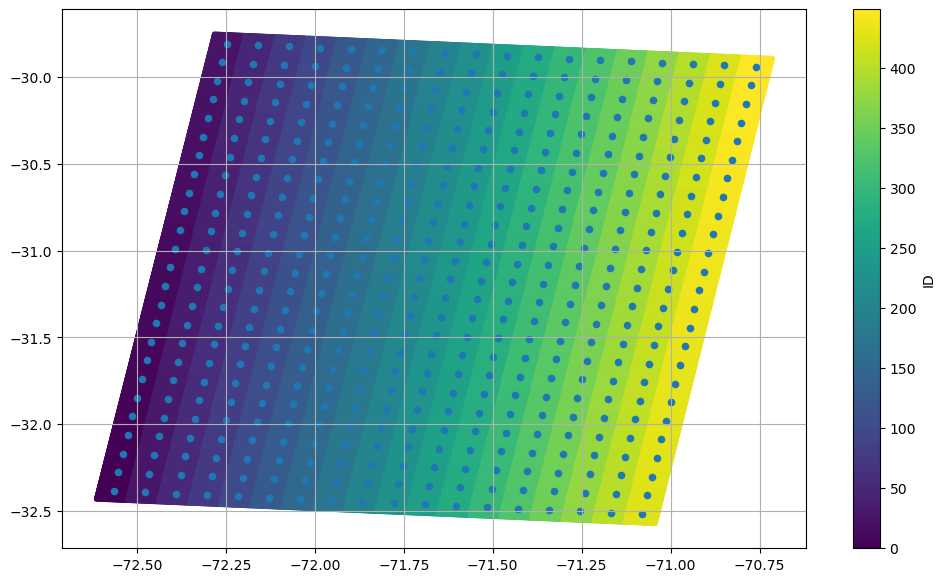

(553500,)


In [38]:
# Initialize arrays to store sub-sources
longitudes = []
latitudes = []
depths = []
pos_x = []
pos_y = []
ID = []
moments = []
time = []
rakes = []
rises = []
dips = []
strikes = []
slip = []
vr = []

for cell_idx, subfault in subfaults.iterrows():
    # Calculate subfault positions
    lon, lat, depth, aux_X, aux_Y  = calculate_subsources_pos(divisions_NX, divisions_NZ, DX, DZ, subfault)

    # Append variables 
    longitudes.append(lon)
    latitudes.append(lat)
    depths.append(depth)
    pos_x.append(aux_X)
    pos_y.append(aux_Y)

    f_ID = np.ones(divisions_NX*divisions_NZ) * cell_idx
    f_moment = np.ones(divisions_NX*divisions_NZ) * (subfault['SF_MOMENT']/ (divisions_NX*divisions_NZ))
    f_time = np.ones(divisions_NX*divisions_NZ) * subfault['TRUP'] 
    f_rakes = np.ones(divisions_NX*divisions_NZ) * subfault['RAKE']
    f_rises = np.ones(divisions_NX*divisions_NZ) * subfault['RISE']
    f_dips = np.ones(divisions_NX*divisions_NZ) * dip
    f_strikes = np.ones(divisions_NX*divisions_NZ) * strike
    f_slip = np.ones(divisions_NX*divisions_NZ) * subfault['SLIP'] #/ n_subsources_per_cell
    f_vr = np.ones(divisions_NX*divisions_NZ) * subfault['Vr']
        
    ID.append(f_ID)
    moments.append(f_moment)
    time.append(f_time)
    rakes.append(f_rakes) 
    rises.append(f_rises) 
    dips.append(f_dips) 
    strikes.append(f_strikes) 
    slip.append(f_slip) 
    vr.append(f_vr)
    
    
# transform into np arrays for ease of use
longitudes = np.squeeze(np.reshape(np.array(longitudes),(-1,1)))
latitudes = np.squeeze(np.reshape(np.array(latitudes),(-1,1)))
depths = np.squeeze(np.reshape(np.array(depths),(-1,1)))
pos_x = np.squeeze(np.reshape(np.array(pos_x),(-1,1)))
pos_y = np.squeeze(np.reshape(np.array(pos_y),(-1,1)))
ID = np.squeeze(np.reshape(np.array(ID),(-1,1)))
moments = np.squeeze(np.reshape(np.array(moments),(-1,1)))
time = np.squeeze(np.reshape(np.array(time),(-1,1)))
rakes = np.squeeze(np.reshape(np.array(rakes),(-1,1)))
rises = np.squeeze(np.reshape(np.array(rises),(-1,1)))
dips = np.squeeze(np.reshape(np.array(dips),(-1,1)))
strikes = np.squeeze(np.reshape(np.array(strikes),(-1,1)))
slip = np.squeeze(np.reshape(np.array(slip),(-1,1)))
vr = np.squeeze(np.reshape(np.array(vr),(-1,1)))

#print(time)

plt.figure(figsize=(12, 7))
scatter = plt.scatter(longitudes, latitudes, s=5, c=ID , cmap='viridis')
cbar = plt.colorbar(scatter)
cbar.set_label('ID')
plt.scatter(subfaults['LON'], subfaults['LAT'], s=20)
plt.grid()
plt.show()
print(moments.shape)

In [40]:
# Total sub-sources and sub-sources per cell
n_total_subsources = len(ID)
print("Total number of subsources:", n_total_subsources)
n_subsources_per_cell = divisions_NX * divisions_NZ
n_cells = len(subfaults)


# Convert ID to integers for safer indexing
ID = ID.astype(int)

# Initialize rupture times
times = np.zeros(n_total_subsources)

# Iterate over each parent cell to assign its sub-sources
for cell_idx, subfault in subfaults.iterrows():
    # Original source coordinates (Double Couple initial)
    lat_dc = subfault['LAT']
    lon_dc = subfault['LON']
    # Rupture time of the original Double Couple source
    trup_dc = subfault['TRUP']
    distancia_dc_hyp = distance.distance((lat_dc, lon_dc), (Lat_hyp, Lon_hyp)).meters

    # Find indices of subsources belonging to the current cell
    indices_subfuentes = np.where(ID == cell_idx)[0]

    for i in indices_subfuentes:
        # Current sub-source coordinates
        lat_sub = latitudes[i]
        lon_sub = longitudes[i]
        
        # Compute the direct distance between DC initial and the sub-source
        #distancia_dc_sub = distance.distance((lat_dc, lon_dc), (lat_sub, lon_sub)).meters

        # Calculate distance from the original source to the hypocenter (Hyp)
        #distancia_dc_hyp = distance.distance((lat_dc, lon_dc), (Lat_hyp, Lon_hyp)).meters

        # Calculate distance from the sub-source to the hypocenter (Hyp)
        distancia_sub_hyp = distance.distance((lat_sub, lon_sub), (Lat_hyp, Lon_hyp)).meters

        # Calculate the distance between the original source and the sub-source
        distancia_dc_sub_ = distancia_sub_hyp - distancia_dc_hyp
        dips_rad = np.deg2rad(dips[i])
        distancia_dc_sub = distancia_dc_sub_ / math.cos(dips_rad)

            # Adjust the rupture time for the sub-source
        if np.isnan(vr[i]) or vr[i] == 0:
            times[i]  = 0
        else:
            times[i] = trup_dc + (distancia_dc_sub / vr[i])


# Create a DataFrame with all sub-sources
subsources_df = pd.DataFrame({
    'lat': latitudes,
    'lon': longitudes,
    'depth': depths,
    'moment': moments,
    'time': times,
    'dip': dips,
    'strike': strikes,
    'rake': rakes,
    'rise': rises,
    'slip': slip,
    'vr': vr,

})


Total number of subsources: 553500


## Forward modelling with numerical GF using Pyrocko:
**STF: Triangular**

In [46]:
# --------------------------------------------------
# Velocity model
# --------------------------------------------------
store_id = 'Husen_CHILE_4HZ'

# We compute the GF for 4hz because we are simulating at 2 hz,
# this folder contain the traces and is in the local disk, 
# it was created in FOMOSTO by Pyrocko. This GF now are precalculated and 
# we can use it without spending much time.

# We need a pyrocko.gf.Engine object which provides us with the traces.
# In this case we are going to use a local
# engine since we are going to query a local store
engine = LocalEngine(store_superdirs=['.'])


In [48]:
# -------------------------------------------------------------
# Forward modelling using the function combi-source by Pyrocko
# -------------------------------------------------------------
# Create the list of sub-sources
sub_faults = []

for idx, row in subsources_df.iterrows():
    try:
        subfault = DCSource(
            lat=row['lat'],  
            lon=row['lon'],  
            depth=row['depth'],  
            dip=row['dip'],  
            strike=row['strike'],  
            rake=row['rake'],  
            time=row['time'],  
            moment=row['moment'],  
            stf=TriangularSTF(duration=row['rise']) #this function is included in pyrocko
        )
        sub_faults.append(subfault)
    except Exception as e:
        print(f"Error creating subfault at row {idx}: {e}")
        
# Safety check: ensure at least one subfault was created
if not sub_faults:
    raise RuntimeError("No subfaults were generated.")

# Create the combined source
combi_source = CombiSource(sub_faults)
print(f"CombiSource created with {len(sub_faults)} subfaults.")

# Station list
stations = [
    {'name': 'VA01', 'lat': -33.023, 'lon': -71.637},
    {'name': 'GO04', 'lat': -30.173, 'lon': -70.799},
    {'name': 'VA03', 'lat': -32.764, 'lon': -70.551},
    {'name': 'CO03', 'lat': -30.839, 'lon': -70.689},
    {'name': 'MT05', 'lat': -33.392, 'lon': -70.738},
    {'name': 'C09O', 'lat': -29.511, 'lon': -71.200},
    {'name': 'C19O', 'lat': -30.093, 'lon': -71.369},
    {'name': 'C01O', 'lat': -29.877, 'lon': -71.238},
]

# Components to compute
channel_codes = 'ENZ'

synthetic_traces = {}

for station in stations:
    # Build one target per component (E, N, Z)
    targets = [
        Target(
            quantity='displacement',
            lat=station['lat'],
            lon=station['lon'],
            store_id=store_id,
            codes=(station['name'], 'NET', 'LOC', ch))
        for ch in channel_codes
    ]

    try:
        print(f"Processing station {station['name']}...")
        response = engine.process(combi_source, targets)
        synthetic_traces[station['name']] = response.pyrocko_traces()
    except Exception as e:
        print(f"Error processing station {station['name']}: {e}")

CombiSource created with 553500 subfaults.
Processing station VA01...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station GO04...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station VA03...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station CO03...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station MT05...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station C09O...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station C19O...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]
Processing station C01O...
[ 99.25  99.5   99.25 ... 110.   110.   110.25]


In [52]:
# --------------------------------------------------
# Save synthetics for each station separately (.npz)
# --------------------------------------------------
out_dir = Path(r"C:/Users/angie/Documents/Kinematic_test/results/this_study_somerville")
out_dir.mkdir(parents=True, exist_ok=True)

for sta, traces in synthetic_traces.items():
    # Extract component arrays
    comp_data = {tr.channel: tr.ydata.astype(np.float32) for tr in traces}
    # Add basic metadata if desired
    comp_data["deltat"] = traces[0].deltat
    comp_data["tmin"]   = traces[0].tmin
    np.savez_compressed(out_dir / f"{sta}_synthetic.npz", **comp_data)
    print(f"{sta} saved to {out_dir}/{sta}_synthetic.npz")


VA01 saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/VA01_synthetic.npz
GO04 saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/GO04_synthetic.npz
VA03 saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/VA03_synthetic.npz
CO03 saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/CO03_synthetic.npz
MT05 saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/MT05_synthetic.npz
C09O saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/C09O_synthetic.npz
C19O saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/C19O_synthetic.npz
C01O saved to C:\Users\angie\Documents\Kinematic_test\results\this_study_somerville/C01O_synthetic.npz


## Some graphs of the results:

In [58]:
# --------------------------------------------------
# Load precomputed synthetic seismograms (.npz) for multiple stations and analyses
# This block reads one .npz file per station from each analysis folder and stores the
# three-component waveforms (E, N, Z) plus basic metadata (deltat, tmin) into a nested
# dictionary: synthetics_all[analysis_name][station_name].
# --------------------------------------------------

# Station list
stations = [
    {'name': 'VA01', 'lat': -33.023, 'lon': -71.637},
    {'name': 'GO04', 'lat': -30.173, 'lon': -70.799},
    {'name': 'VA03', 'lat': -32.764, 'lon': -70.551},
    {'name': 'CO03', 'lat': -30.839, 'lon': -70.689},
    {'name': 'MT05', 'lat': -33.392, 'lon': -70.738},
    {'name': 'C09O', 'lat': -29.511, 'lon': -71.200},
    {'name': 'C19O', 'lat': -30.093, 'lon': -71.369},
    {'name': 'C01O', 'lat': -29.877, 'lon': -71.238},
]
# Names of the analysis and their corresponding folders
analyses = {
    
    "This study":   r"C:/Users/angie/Documents/Kinematic_test/results/this_study_somerville",
}

# Main dictionary: analysis -> station -> data
synthetics_all = {}

for analysis_name, syn_dir in analyses.items():
    synthetic_loaded = {}

    for sta in stations:
        sta_name = sta["name"]
        fpath = os.path.join(syn_dir, f"{sta_name}_synthetic.npz")
        data = np.load(fpath, allow_pickle=True)

        synthetic_loaded[sta_name] = {
            "E": data["E"],
            "N": data["N"],
            "Z": data["Z"],
            "deltat": float(np.squeeze(data["deltat"])),
            "tmin": float(np.squeeze(data["tmin"])),
        }

    synthetics_all[analysis_name] = synthetic_loaded

print("All synthetics loaded successfully")

All synthetics loaded successfully


In [64]:
# -------------------------
# 0. Official station list
# -------------------------
stations = ['VA01', 'GO04', 'VA03', 'CO03', 'MT05', 'C09O', 'C19O', 'C01O']
components = ['HNE', 'HNN', 'HNZ']
#cut_duration = 300.01  # seconds
data_dir = "C:/Users/angie/Documents/Kinematic_test"

# -------------------------
# 1. Station-specific parameters
# -------------------------
dt_obs_dict = {
    'VA01': 0.01, 'GO04': 0.01, 'VA03': 0.01, 'CO03': 0.01,
    'MT05': 0.01, 'C09O': 0.005, 'C19O': 0.005, 'C01O': 0.005
}

# -------------------------
# 2. Load observed files
# -------------------------
obs_files = {}
for sta in stations:
    obs_files[sta] = {}
    for comp in components:
        pattern = os.path.join(data_dir, f"*{sta}-{comp}.txt")
        matches = glob.glob(pattern)
        if not matches:
            raise FileNotFoundError(f"No file found for {sta}-{comp}")
        obs_files[sta][comp] = matches[0]

# -------------------------
# 3. Preprocessing function
# -------------------------
def preprocess(x, df):
    x = signal.detrend(x, type='constant')
    x = polynomial(x, order=1, plot=False)
    x = bandpass(x, 0.1, 1.0, df=df, corners=4, zerophase=True)
    return x

# -------------------------
# 4. Process observed data
# -------------------------
obs_e_dict = {}
obs_n_dict = {}
obs_z_dict = {}

for sta in stations:
    print(f'Processing observed data - station: {sta}')
    dt_obs = dt_obs_dict[sta]

    acc_e = np.loadtxt(obs_files[sta]['HNE'])
    acc_n = np.loadtxt(obs_files[sta]['HNN'])
    acc_z = np.loadtxt(obs_files[sta]['HNZ'])

    obs_e = preprocess(acc_e, 1 / dt_obs)
    obs_n = preprocess(acc_n, 1 / dt_obs)
    obs_z = preprocess(acc_z, 1 / dt_obs)

    obs_e_dict[sta] = obs_e
    obs_n_dict[sta] = obs_n
    obs_z_dict[sta] = obs_z

print("Observed data processed.\n")

# -------------------------
# 5. Process SYNTHETICS 
# -------------------------
acc_sim_e_dict_all = {}
acc_sim_n_dict_all = {}
acc_sim_z_dict_all = {}

for analysis_name in synthetics_all:
    acc_sim_e_dict_all[analysis_name] = {}
    acc_sim_n_dict_all[analysis_name] = {}
    acc_sim_z_dict_all[analysis_name] = {}

    for sta in stations:
        print(f'Processing analysis {analysis_name} - station: {sta}')
        dt_sim = synthetics_all[analysis_name][sta]['deltat']

        acc_sim_e = acc_sim_n = acc_sim_z = None

        for comp in ['E', 'N', 'Z']:
            y = synthetics_all[analysis_name][sta][comp]
            y = preprocess(y, 1 / dt_sim)

            v = np.gradient(y, dt_sim)
            v = preprocess(signal.detrend(v, type='constant'), 1 / dt_sim)

            acc = np.gradient(v, dt_sim)
            acc = preprocess(signal.detrend(acc, type='constant'), 1 / dt_sim)

            if comp == 'E':
                acc_sim_e = acc
            elif comp == 'N':
                acc_sim_n = acc
            elif comp == 'Z':
                acc_sim_z = acc

        acc_sim_e_dict_all[analysis_name][sta] = acc_sim_e
        acc_sim_n_dict_all[analysis_name][sta] = acc_sim_n
        acc_sim_z_dict_all[analysis_name][sta] = acc_sim_z

print("\nSynthetics processed")


Processing observed data - station: VA01
Processing observed data - station: GO04
Processing observed data - station: VA03
Processing observed data - station: CO03
Processing observed data - station: MT05
Processing observed data - station: C09O
Processing observed data - station: C19O
Processing observed data - station: C01O
Observed data processed.

Processing analysis This study - station: VA01
Processing analysis This study - station: GO04
Processing analysis This study - station: VA03
Processing analysis This study - station: CO03
Processing analysis This study - station: MT05
Processing analysis This study - station: C09O
Processing analysis This study - station: C19O
Processing analysis This study - station: C01O

Synthetics processed


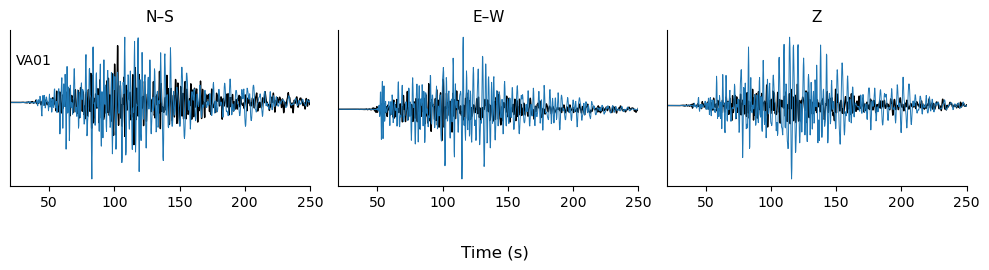

In [94]:
# --------------------------------------------------
# Plot observed vs. synthetic acceleration for one station (N/E/Z) with an optional time shift
# The synthetic traces can be shifted in time by padding/cropping (keeping the same length).
# --------------------------------------------------

# --------------------
# Settings
# --------------------
sta = "VA01"
analysis_name = "This study"     # key name in synthetics_all
shift = 10.5  # [s] +: pad zeros at the beginning | -: cut the beginning and pad zeros at the end
tmin_plot, tmax_plot = 20.0, 250.0

# Vertical separation between observed and synthetic within the same panel
# (visual offset only; NO scaling and NO additional filtering)
offset_factor = 0  # multiplier of max(|obs|,|syn|) within the plotting window

# --------------------
# Shift function: pad/crop the array while keeping the same length
# --------------------
def shift_by_padding(y, nshift):
    """
    Shift convention:
      nshift > 0: prepend nshift zeros and truncate the end (keeps N)
      nshift < 0: remove -nshift samples from the start and append zeros (keeps N)
    """
    y = np.asarray(y)
    N = y.size

    if nshift == 0:
        return y.copy()

    if nshift > 0:
        return np.concatenate([np.zeros(nshift, dtype=y.dtype), y])[:N]

    k = -nshift
    if k >= N:
        return np.zeros(N, dtype=y.dtype)
    return np.concatenate([y[k:], np.zeros(k, dtype=y.dtype)])


# --------------------
# Map OBS (HNN/HNE/HNZ) -> N/E/Z
# --------------------
dt_obs = dt_obs_dict[sta]
obs_map = {
    "N": obs_n_dict[sta],
    "E": obs_e_dict[sta],
    "Z": obs_z_dict[sta],
}

# --------------------
# Map processed SYN (acc_sim_*) -> N/E/Z
# --------------------
sim_map = {
    "N": acc_sim_n_dict_all[analysis_name][sta],
    "E": acc_sim_e_dict_all[analysis_name][sta],
    "Z": acc_sim_z_dict_all[analysis_name][sta],
}

# Synthetic timing info
dt_syn   = synthetics_all[analysis_name][sta]["deltat"]
tmin_syn = synthetics_all[analysis_name][sta]["tmin"]

# Convert shift (s) -> samples (based on synthetic dt)
nshift = int(round(shift / dt_syn))

# --------------------
# Subplots 1 row x 3 columns
# --------------------
fig, axs = plt.subplots(1, 3, figsize=(10, 2.6), sharex=True)
fig.subplots_adjust(wspace=0.35)

titles = {"N": "N–S", "E": "E–W", "Z": "Z"}

for j, comp in enumerate(["N", "E", "Z"]):
    ax = axs[j]

    # --- Observed (no scaling) ---
    yobs = obs_map[comp]
    tobs = np.arange(len(yobs)) * dt_obs
    m_obs = (tobs >= tmin_plot) & (tobs <= tmax_plot)

    # --- Synthetic (no scaling + time shift via padding/cropping) ---
    ysyn = sim_map[comp]
    ysyn_shifted = shift_by_padding(ysyn, nshift)

    tsyn = tmin_syn + np.arange(len(ysyn_shifted)) * dt_syn
    m_syn = (tsyn >= tmin_plot) & (tsyn <= tmax_plot)

    # --- Offset used only to separate traces visually (does NOT change relative amplitudes) ---
    # Uses the maximum amplitude within the window (or the full series if the window is empty)
    Aobs = np.max(np.abs(yobs[m_obs])) if np.any(m_obs) else np.max(np.abs(yobs))
    Asyn = np.max(np.abs(ysyn_shifted[m_syn])) if np.any(m_syn) else np.max(np.abs(ysyn_shifted))
    off = offset_factor * max(Aobs, Asyn, 1e-12)


    # Stacked traces (observed on top, synthetic below)
    ax.plot(tobs[m_obs], yobs[m_obs] + off, color="k", lw=1.0)
    ax.plot(tsyn[m_syn], ysyn_shifted[m_syn] - off, color="tab:blue", lw=0.7)

    ax.set_title(titles[comp], fontsize=11)
    ax.set_xlim(tmin_plot, tmax_plot)
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Global labels
axs[0].text(0.02, 0.78, f"{sta}", transform=axs[0].transAxes, fontsize=10)

fig.supxlabel("Time (s)", y=-0.02)
plt.tight_layout()
plt.show()
